## Imports and initialization

In [26]:
import numpy as np
import pandas as pd

import requests
import zipfile
import io

import math

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import RocCurveDisplay, auc, accuracy_score, classification_report, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# defining global usage arrays and a read function to start out the notebook

numeric_cols = ['age', 'education-years', 'capital-gain', 'capital-loss', 'week-worktime']
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

def read_csv(path):
    columns = [
        'age', 'workclass', 'sample-weight', 'education', 'education-years',
        'marital-status', 'occupation', 'relationship', 'race',
        'gender', 'capital-gain', 'capital-loss', 'week-worktime', 'native-country', 'income'
    ]
    return pd.read_csv(path, comment = '|', names = columns)

def get_dataset(name):
  url = "https://archive.ics.uci.edu/static/public/2/adult.zip"

  response = requests.get(url)

  files = io.BytesIO(response.content)

  with zipfile.ZipFile(files) as z:
    with z.open(name) as dataset:
        df = read_csv(dataset)
  return df

In [4]:
df = get_dataset('adult.data')
df

,age,workclass,sample-weight,education,education-years,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,week-worktime,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## First Data Analysis

here We will perform a simple data analysis to understand the features and what useful information we have on this dataset.

In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,32561.0,NaN,NaN,NaN,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
workclass,32561,9,Private,22696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample-weight,32561.0,NaN,NaN,NaN,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education,32561,16,HS-grad,10501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education-years,32561.0,NaN,NaN,NaN,10.080679,2.57272,1.0,9.0,10.0,12.0,16.0
marital-status,32561,7,Married-civ-spouse,14976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,32561,15,Prof-specialty,4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,32561,6,Husband,13193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,32561,5,White,27816,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,32561,2,Male,21790,NaN,NaN,NaN,NaN,NaN,NaN,NaN


now, let's perform a quick look on diagrams that shows the amount of samples based on feature by income, both numeric and categorical

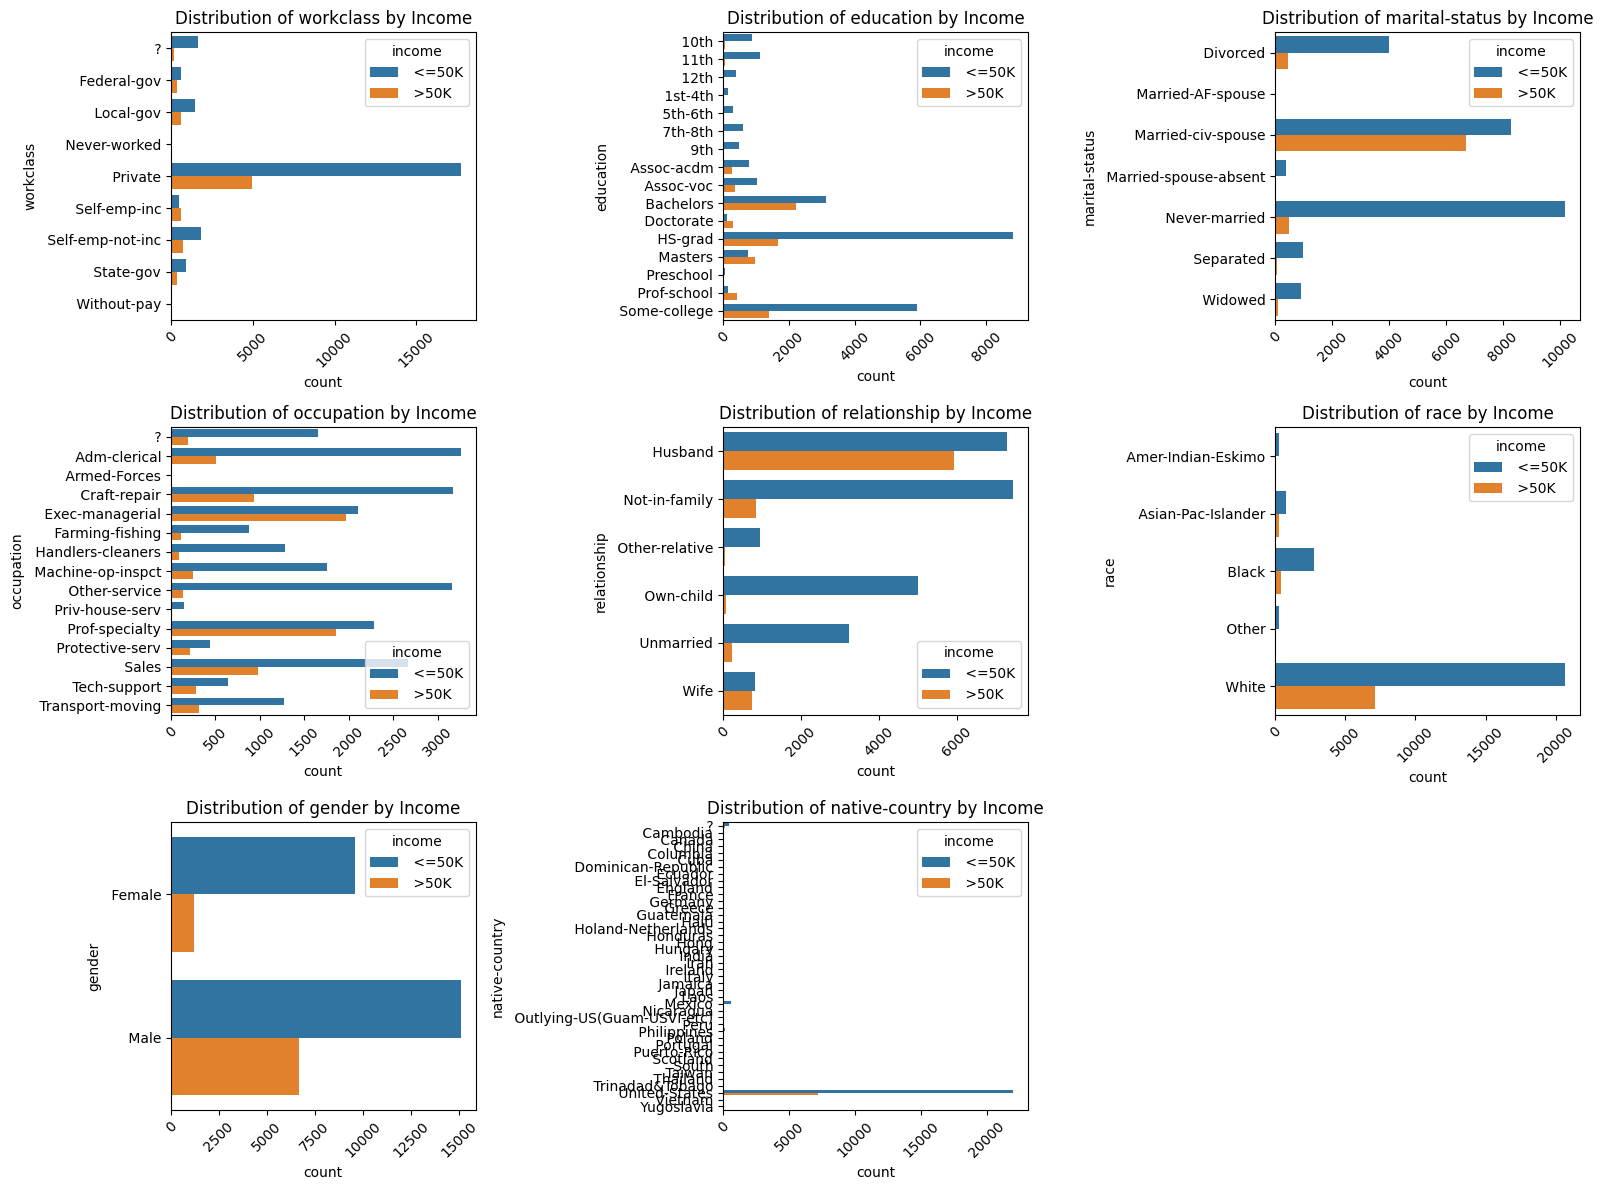

In [6]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    data_plot = df.groupby([col, 'income']).size().reset_index(name='count')
    sns.barplot(data=data_plot, y=col, x='count', hue='income')
    plt.title(f'Distribution of {col} by Income')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

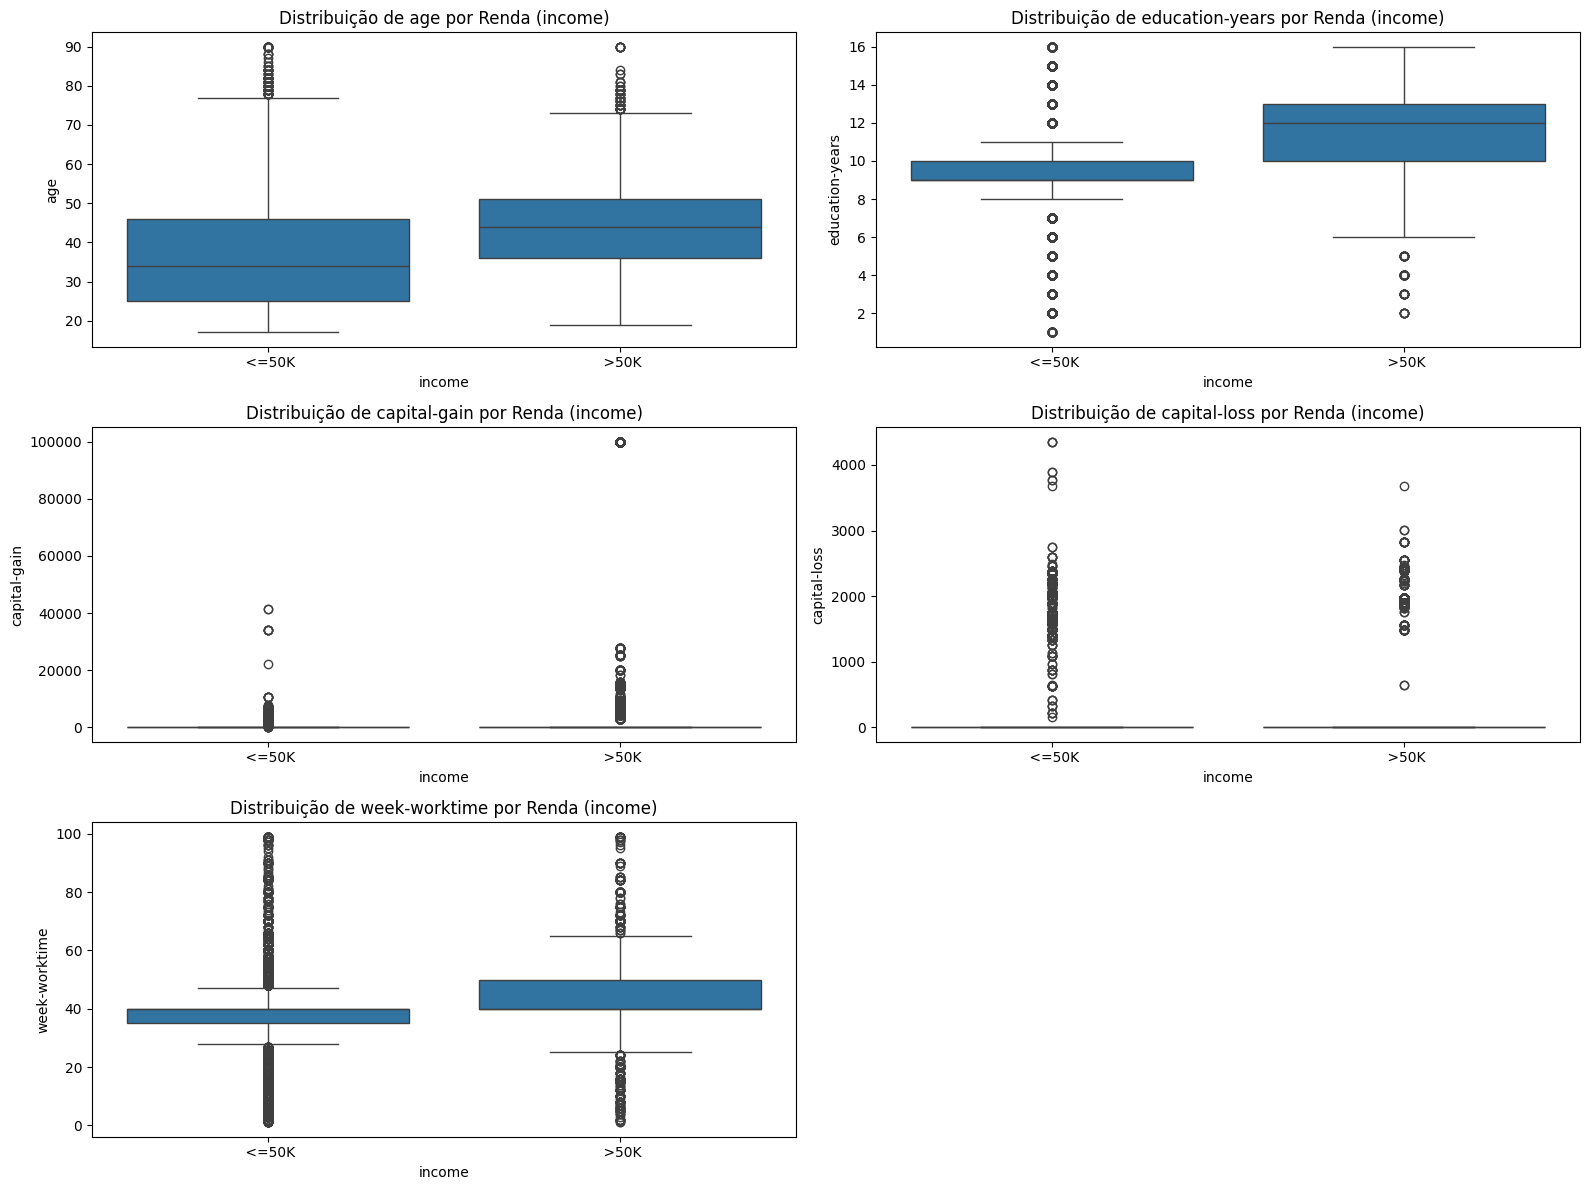

In [ ]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x='income', y=col)
    plt.title(f'Distribuição de {col} por Renda (income)')

plt.tight_layout()
plt.show()

One important thing that we can note from this is that the dataframe has some missing values for some labels. Let's first clean the dataframe and then peform some analysis, so we can apply transformations to the data and start the training process

In [ ]:
rows_with_question_mark = (df == ' ?').any(axis = 1)
num_rows_with_question_mark = rows_with_question_mark.sum()

print(f"Number of rows containing '?': {num_rows_with_question_mark}")

question_mark_counts = (df == ' ?').sum()

print("Number of ` ?` by column:")

for col, count in question_mark_counts.items():
    if (count == 0): continue
    print(f"\t- Feature '{col}': {count}")

Number of rows containing '?': 2399
Number of ` ?` by column:
	- Feature 'workclass': 1836
	- Feature 'occupation': 1843
	- Feature 'native-country': 583


as we see here, only 2399 samples have '?' values, which means maybe its not necessary to remove or change it, since it represents only ~7% of the total samples. For this study, it will just be replaced with 'unknown'.

## Data cleaning

In [7]:
def normalize_dataframe(data):
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    transformed_array = preprocessor.fit_transform(data)

    new_columns = preprocessor.get_feature_names_out()

    df_transformed = pd.DataFrame(data = transformed_array, columns = new_columns)

    return df_transformed

def clean_dataframe(data):
    data.columns = data.columns.str.strip()
    data = data.dropna()

    data['income'] = data.income.str.rstrip('.') # test dataset has a dot at the end

    data = data.drop('sample-weight', axis = 1)

    data = data.map(lambda x : x.strip() if isinstance(x, str) else x)

    data = data.replace('?', 'unknown')

    data['income'] = (data['income'] == '>50K').astype(int)

    return data

In [8]:
dataframe = clean_dataframe(df)
dataframe.head()

,age,workclass,education,education-years,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,week-worktime,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Training and loading test dataset

In [9]:
x = dataframe.drop('income', axis = 1)
y = dataframe['income']

In [10]:
# train data
x_train = normalize_dataframe(x)
x_train.drop('cat__native-country_Holand-Netherlands', axis = 1, inplace = True)

y_train = y

x_train

,num__age,num__education-years,num__capital-gain,num__capital-loss,num__week-worktime,cat__workclass_Federal-gov,cat__workclass_Local-gov,cat__workclass_Never-worked,cat__workclass_Private,cat__workclass_Self-emp-inc,...,cat__native-country_Puerto-Rico,cat__native-country_Scotland,cat__native-country_South,cat__native-country_Taiwan,cat__native-country_Thailand,cat__native-country_Trinadad&Tobago,cat__native-country_United-States,cat__native-country_Vietnam,cat__native-country_Yugoslavia,cat__native-country_unknown
0,0.030671,1.134739,0.148453,-0.21666,-0.035429,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.837109,1.134739,-0.145920,-0.21666,-2.222153,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.042642,-0.420060,-0.145920,-0.21666,-0.035429,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.057047,-1.197459,-0.145920,-0.21666,-0.035429,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.775768,1.134739,-0.145920,-0.21666,-0.035429,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.849080,0.746039,-0.145920,-0.21666,-0.197409,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32557,0.103983,-0.420060,-0.145920,-0.21666,-0.035429,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32558,1.423610,-0.420060,-0.145920,-0.21666,-0.035429,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32559,-1.215643,-0.420060,-0.145920,-0.21666,-1.655225,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
y_train.head()

,income
0,0
1,0
2,0
3,0
4,0


In [24]:
# test data
test_df = get_dataset('adult.test')
test_df = clean_dataframe(test_df)

X_test = test_df.drop('income', axis = 1)
y_test = test_df['income']

x_test = normalize_dataframe(X_test)

now that we have both train and test datasets properly cleaned and normalized, we can start testing our model and some evaluation strategies.

In [13]:
model = LogisticRegression(max_iter=500)
model.fit(x_train, y_train)

LogisticRegression(max_iter=500)

In [14]:
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)[:, 1]

print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.73      0.60      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.76      0.78     16281
weighted avg       0.85      0.85      0.85     16281



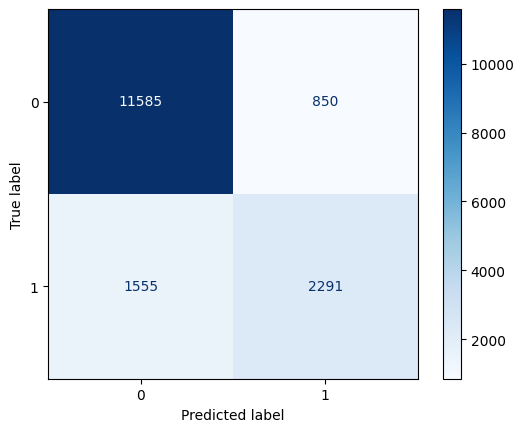

In [15]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

We see here that the overall accuracy it is not the best, but still decent. How to make it better? maybe the train dataset could have ignored all the '?' values or select less features for training and testing. Or use a model to predict the missing values given the entire dataset. Let's try some of those

## Other strategies

### Multi-Layer Neural Network

For this approach we opted to use the Pytorch library, and based the code on fonts like the classes notebooks (especially [this one](https://colab.research.google.com/drive/1XxYYg51nSBHRpzEdi1WW8MO0j2qMfM1i?usp=sharing#scrollTo=AWXkmtwj6SqE)), chatGPT and other sites and forums like, stackoverflow and medium

In [ ]:
# Import of the NN Librarys and Packages that will be used
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data_utils

In [ ]:
# Creation of a class to convert the Pandas dataframe to a PyTorch format
class IncomeDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# The Classifier Class, we wanted to explore it with more neurons, but we reduced the scope because of time constraints
class IncomeNeuralNetworkPredictor(nn.Module):
    def __init__(self, input_dim):
        super(IncomeNeuralNetworkPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).flatten()

In [ ]:
dataset_pt = IncomeDataset(x_train, y_train)
dataloader = DataLoader(dataset_pt, batch_size=16, shuffle=True)

input_dim = x_train.shape[1]
modelMLP = IncomeNeuralNetworkPredictor(input_dim)

criterion = nn.BCELoss()
optimizer = optim.SGD(modelMLP.parameters(), lr=0.1)


In [ ]:
!pip install tqdm

#### Train and Evaluation

 14%|█▍        | 50/350 [02:15<13:06,  2.62s/it]

Época [50/350], Loss: 0.4371


 29%|██▊       | 100/350 [04:19<10:21,  2.48s/it]

Época [100/350], Loss: 0.0009


 43%|████▎     | 150/350 [06:22<08:02,  2.41s/it]

Época [150/350], Loss: 0.3183


 57%|█████▋    | 200/350 [08:25<06:02,  2.42s/it]

Época [200/350], Loss: 0.0000


 71%|███████▏  | 250/350 [10:37<04:21,  2.62s/it]

Época [250/350], Loss: 0.0011


 86%|████████▌ | 300/350 [12:42<02:05,  2.52s/it]

Época [300/350], Loss: 0.1104


100%|██████████| 350/350 [14:51<00:00,  2.55s/it]

Época [350/350], Loss: 0.2094


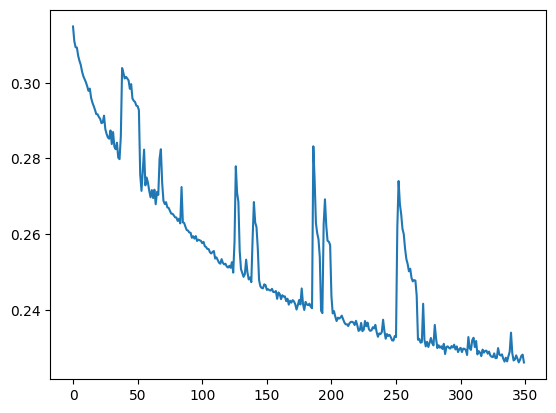

In [ ]:
from tqdm import tqdm
num_epochs = 350

epoch_cost = []

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for features, targets in dataloader:
      optimizer.zero_grad()
      outputs = model(features)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    # # Forward pass
    # outputs = model(dataset_pt)
    # loss = criterion(outputs, y_train)

    # # Backward pass e otimização
    # optimizer.zero_grad()  # Zera os gradientes
    # loss.backward()  # Backpropagation
    # optimizer.step()  # Atualiza os pesos
    epoch_cost.append(epoch_loss/len(dataloader))

    if (epoch+1) % 50 == 0:
        print(f'Época [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

plt.plot(epoch_cost)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(32561, 106)
(16281, 106)


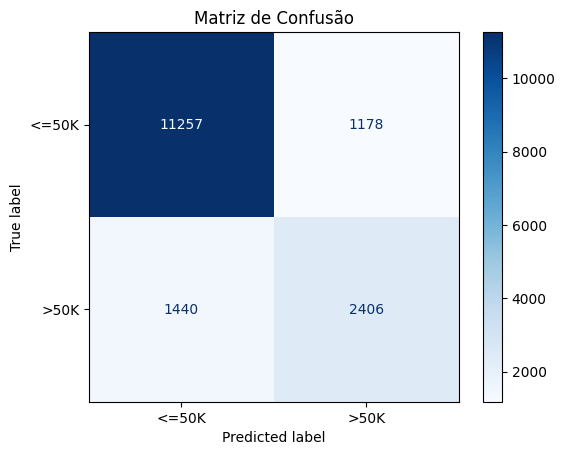

In [ ]:
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)

# Avaliação do modelo
modelMLP.eval()  # Coloca o modelo em modo de avaliação
with torch.no_grad():  # Desativa o cálculo do gradiente para eficiência
    y_pred_probs = model(x_test_tensor)
    y_pred_labels = (y_pred_probs.flatten() >= 0.5).int()  # Converte para rótulos binários, visto que a funcao Sigmoide retorna uma probabilidade


cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")

plt.show()

In [ ]:
# Test of other metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)

print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Revocação: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Acurácia: 0.84
Precisão: 0.67
Revocação: 0.63
F1-Score: 0.65


Based on the metrics, we see that the results were lower than expected, with an Accuracy score lower than the model built with Logistic Regression. To see an improvement, some tests could be made:

*   Increase the number of epochs.
*   Adjust the learning rate to minimize spikes in the loss graph.
*   Consider switching to a more advanced optimizer, such as Adam.
*   Explore additional potential changes."

For an bigger explanation of the results see the documentation

### Using KFold

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_accuracies = []

for train_index, test_index in kf.split(x_train):
    X_train_kf, X_test_kf = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]
    model.fit(X_train_kf, y_train_kf)
    y_pred_kf = model.predict(X_test_kf)
    acc = accuracy_score(y_test_kf, y_pred_kf)
    kf_accuracies.append(acc)

print(f"K-Fold Accuracy Scores: {kf_accuracies}")
print(f"Mean Accuracy (K-Fold): {np.mean(kf_accuracies):.2f}")

K-Fold Accuracy Scores: [0.8584369722094273, 0.8476658476658476, 0.8485872235872236, 0.8516584766584766, 0.8513513513513513]
Mean Accuracy (K-Fold): 0.85


### Removing null values from training dataset



In [17]:
# train data
x_train_reduced = x.replace('unknown', None).dropna()

dropped_indices = x.index.difference(x_train_reduced.index)

x_train_reduced = normalize_dataframe(x_train_reduced)

x_train_reduced.drop('cat__native-country_Holand-Netherlands', axis = 1, inplace = True)

y_train_reduced = y.drop(dropped_indices)

In [18]:
x_test_reduced = x_test.copy()

x_test_reduced.drop('cat__native-country_unknown', axis = 1, inplace = True)
x_test_reduced.drop('cat__occupation_unknown', axis = 1, inplace = True)
x_test_reduced.drop('cat__workclass_Never-worked', axis = 1, inplace = True)
x_test_reduced.drop('cat__workclass_unknown', axis = 1, inplace = True)

y_test_reduced = y_test

In [19]:
model = LogisticRegression(max_iter=500)
model.fit(x_train_reduced, y_train_reduced)

LogisticRegression(max_iter=500)

In [20]:
y_pred = model.predict(x_test_reduced)
y_pred_prob = model.predict_proba(x_test_reduced)[:, 1]

print(classification_report(y_test_reduced, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.72      0.60      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.77      0.78     16281
weighted avg       0.85      0.85      0.85     16281



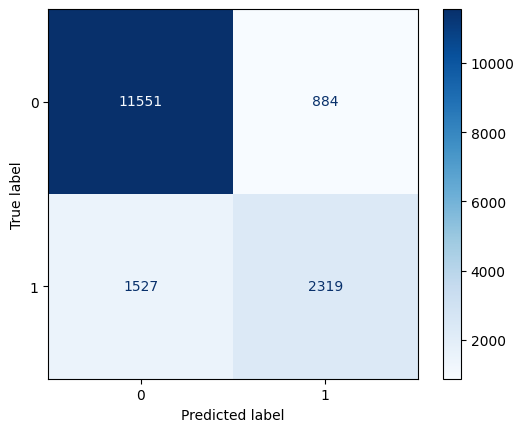

In [21]:
cm = confusion_matrix(y_test_reduced, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Predicting using the RandomForest model

In [27]:
x_rf = x.copy()
y_rf = y.copy()

categorical_columns = x_rf.select_dtypes(include=['object']).columns
x_rf = pd.get_dummies(x_rf, columns=categorical_columns)
x_rf.drop('native-country_Holand-Netherlands', axis = 1, inplace = True)

x_test_rf = X_test
categorical_columns = x_test_rf.select_dtypes(include=['object']).columns
x_test_rf = pd.get_dummies(x_test_rf, columns=categorical_columns)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_rf, y_rf)

y_pred = model.predict(x_test_rf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8435599778883361

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90     12435
           1       0.69      0.61      0.65      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.76      0.77     16281
weighted avg       0.84      0.84      0.84     16281



In [28]:
importances = model.feature_importances_
feature_names = x_rf.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                                      Feature  Importance
0                                         age    0.228310
4                               week-worktime    0.115977
2                                capital-gain    0.106959
32          marital-status_Married-civ-spouse    0.061642
1                             education-years    0.059344
..                                        ...         ...
27                        education_Preschool    0.000065
91  native-country_Outlying-US(Guam-USVI-etc)    0.000028
38                    occupation_Armed-Forces    0.000016
79                    native-country_Honduras    0.000009
7                      workclass_Never-worked    0.000003

[106 rows x 2 columns]


As we can see here, there were no improvement on the accuracy, but we got a good hint: it seems the numeric features are the ones with most influence. Let's try a final approach, this time using only numeric columns for training and then only the categorical columns.

### Only numerical columns

In [29]:
normalized_numeric_cols = ['num__' + col for col in numeric_cols]

numeric_x_train = x_train[normalized_numeric_cols]
numeric_x_test = x_test[normalized_numeric_cols]

model = LogisticRegression(max_iter=500)
model.fit(numeric_x_train, y_train)

LogisticRegression(max_iter=500)

In [30]:
y_pred = model.predict(numeric_x_test)
y_pred_prob = model.predict_proba(numeric_x_test)[:, 1]

print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     12435
           1       0.68      0.38      0.49      3846

    accuracy                           0.81     16281
   macro avg       0.76      0.66      0.69     16281
weighted avg       0.80      0.81      0.79     16281



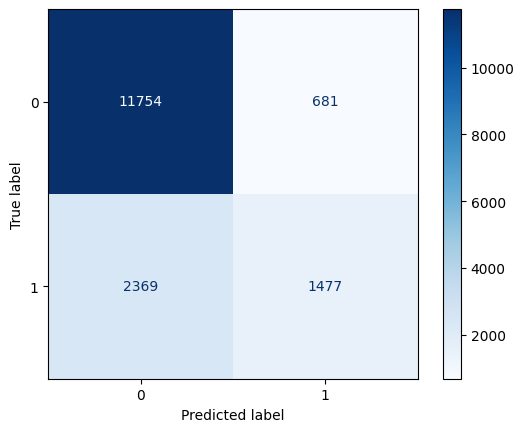

In [31]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Only categorical columns

In [32]:
normalized_numeric_cols = ['num__' + col for col in numeric_cols]

categorical_x_train = x_train.drop(columns = normalized_numeric_cols)
categorical_x_test = x_test.drop(columns = normalized_numeric_cols)

model = LogisticRegression(max_iter=1000)
model.fit(categorical_x_train, y_train)

LogisticRegression(max_iter=1000)

In [33]:
y_pred = model.predict(categorical_x_test)
y_pred_prob = model.predict_proba(categorical_x_test)[:, 1]

print(classification_report(y_test, y_pred, zero_division = 0))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12435
           1       0.70      0.54      0.61      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.73      0.75     16281
weighted avg       0.83      0.84      0.83     16281



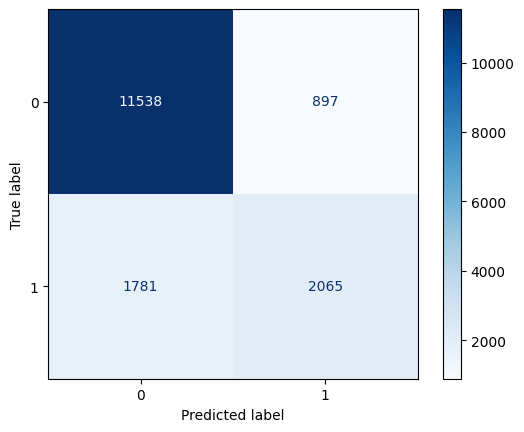

In [34]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()